# Orders

✏️ **Exercise**

Today, we will investigate the **orders**, and their associated **review score**.

👉 Our goal is to create a DataFrame with the following features:


| feature_name 	| type 	| description 	|
|:---	|:---:	|:---	|
| `order_id` 	| str 	| the id of the order 	|
| `wait_time` 	| float 	| the number of days between order_purchase_timestamp and order_delivered_customer_date 	|
| `expected_wait_time` 	| float 	| the number of days between order_purchase_timestamp and estimated_delivery_date 	|
| `delay_vs_expected` 	| float 	| if the actual order_delivered_customer_date is later than the estimated delivery date, returns the number of days between the two dates, otherwise return 0 	|
| `order_status` 	| str 	| the status of the order 	|
| `dim_is_five_star` 	| int 	| 1 if the order received a five-star review, 0 otherwise 	|
| `dim_is_one_star` 	| int 	| 1 if the order received a one_star, 0 otherwise 	|
| `review_score` 	| int 	| from 1 to 5 	|
| `number_of_items` 	| int 	| number of items that the order contains 	|
| `number_of_sellers` 	| int 	| number of sellers involved in the order 	|
| `price` 	| float 	| total price of the order paid by customer 	|
| `freight_value` 	| float 	| value of the freight paid by customer 	|
| `distance_customer_seller` 	| float 	| the distance in km between customer and seller (optional) 	|  
  
⚠️ We also want to filter out "non-delivered" orders, unless explicitly specified, otherwise we cannot compute the potential delays.

❓ **Your challenge**: 

- Implement each feature as a separate method within the `Order` class available at `olist/order.py`
- Then, create a method `get_training_data()` that returns the complete DataFrame **without `NaN`s**.

💡 Suggested methodology:
- Use the notebook below to write and test your code step-by-step first
- Then copy the code into `order.py` once you are certain of your code logic
- Focus on the data manipulation logic now, we will analyse the dataset visually in the next challenges

🔥 Notebook best practices (must-read) 👇

<details>
    <summary>▸ <i>click here</i></summary>

From now on, exploratory notebooks are going to become pretty long, and we strongly advise you to follow these notebook principles:
- Code your logic so that your Notebook can always be ran from top to bottom without crashing (Run --> Run All Cells)
- Name your variables carefully 
- Use dummy names such as `tmp` or `_` for intermediary steps when you know you won't need them for long
- Clear your code and merge cells when relevant to minimize Notebook size (`Shift-M`)
- Make heavy use of of the collapsible headings and the table of content (call a TA if you can't find them)
- Use the following shortcuts 
    - `a` to insert a cell above
    - `b` to insert a cell below
    - `dd` to delete a cell
    - `esc` and `arrows` to move between cells
    - `Shift-Enter` to execute cell and move focus to the next one
    - use `Shift + Tab` when you are between method brackets e.g. `groupby()` to get the docs! Repeat a few times to open it permanently

</details>





In [1]:
# Auto reload imported module every time a jupyter cell is executed (handy for olist.order.py updates)
%load_ext autoreload
%autoreload 2

In [2]:
# Import usual modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

In [4]:
# Import olist data
from olist.data import Olist
olist = Olist()
data = olist.get_data()

In [5]:
# What datasets do we have access to now ?
data.keys()

dict_keys(['sellers', 'order_reviews', 'order_items', 'customers', 'orders', 'order_payments', 'product_category_name_translation', 'products', 'geolocation'])

In [6]:
orders = data['orders'].copy() # good practice to be sure not to modify your `data` variable

assert(orders.shape == (99441, 8))


## 1. Code `order.py`

### a) `get_wait_time`
    ❓ Return a Dataframe with:
           order_id, wait_time, expected_wait_time, delay_vs_expected, order_status


In [7]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


🎁 We give you the pseudo-code below 👇 for this first method:

> 1. Inspect the `orders` dataframe
2. Filter the dataframe on `delivered orders`
3. Handle `datetime`
    - Take time to understand what python [`datetime`](https://docs.python.org/3/library/datetime.html) objects are
    - and convert dates from "string" type to "pandas.datetime' using [`pandas.to_datetime()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html)
4. Compute `wait_time` in days as a decimal number (starting from `order_purchase_timestamp`)
5. Compute `expected_wait_time` in days as a decimal number (starting from `order_purchase_timestamp`)
6. Compute `delay_vs_expected` in days as a decimal number (put `0` if the order is delivered earlier than estimated)
7. Check the new dataframe 
8. Once you are satisfied with your code, you can carefully copy-paste it from the notebook to to `olist/order.py`
9. Now try to load the data using your method in `orders.py`
10. Your code will probably not work straightaway
11. Make the necessary changes to make it work from inside a `.py` file

We want `wait_time`, `expected_wait_time` and `delay_vs_expected` in decimal numbers, not as integers. Think about it: a wait time of 8.1 or 8.9 days is a big difference. So you can't use Pandas' `dt.day` because that rounds both down to 8.

<details>
    <summary>💡Hint</summary>

For both `wait_time` and `delay_vs_expected`, you need to subtract the relevant dates/timestamps to get the time difference between the `pandas.datetime` objects. Then, you can either use [`datetime.timedelta()`](https://docs.python.org/3/library/datetime.html#timedelta-objects) or [`np.timedelta64()`](https://numpy.org/doc/stable/reference/arrays.datetime.html#datetime-and-timedelta-arithmetic) to find out how many days that subtraction represents!

</details>

In [8]:



# Filter for delivered orders only
delivered_orders = orders[orders['order_status'] == 'delivered'].copy()

    # Convert string timestamps to pandas datetime objects
date_columns = [
        'order_purchase_timestamp',
        'order_approved_at',
        'order_delivered_carrier_date',
        'order_delivered_customer_date',
        'order_estimated_delivery_date'
    ]

for col in date_columns:
    if col in delivered_orders.columns:
            delivered_orders[col] = pd.to_datetime(delivered_orders[col])

    # Calculate wait time (days between purchase and delivery to customer)
delivered_orders['wait_time'] = (
        delivered_orders['order_delivered_customer_date'] -
        delivered_orders['order_purchase_timestamp']
    ).dt.total_seconds() / (24 * 3600)  # Convert seconds to days as decimal

    # Calculate expected wait time (days between purchase and estimated delivery)
delivered_orders['expected_wait_time'] = (
        delivered_orders['order_estimated_delivery_date'] -
        delivered_orders['order_purchase_timestamp']
    ).dt.total_seconds() / (24 * 3600)  # Convert seconds to days as decimal

    # Calculate delay vs expected (negative means delivered earlier than estimated)
delay = (delivered_orders['order_delivered_customer_date'] -
             delivered_orders['order_estimated_delivery_date']).dt.total_seconds() / (24 * 3600)

    # Set delay to 0 if order was delivered earlier than estimated (per instruction #6)
delivered_orders['delay_vs_expected'] = np.maximum(delay, 0)

    # Select and return only the required columns
result = delivered_orders[['order_id', 'wait_time', 'expected_wait_time',
                              'delay_vs_expected', 'order_status']]


👀 Check the dataframe you've just created. <br/> 

💪 When your code works, bring your code over to `olist/order.py` <br/>

🧪 Now, test it by running the following cell 👇 

In [9]:
# Test your code here
from olist.order import Order
Order().get_wait_time()

,order_id,wait_time,expected_wait_time,delay_vs_expected,order_status
0,e481f51cbdc54678b7cc49136f2d6af7,8.436574,15.544063,0.0,delivered
1,53cdb2fc8bc7dce0b6741e2150273451,13.782037,19.137766,0.0,delivered
2,47770eb9100c2d0c44946d9cf07ec65d,9.394213,26.639711,0.0,delivered
3,949d5b44dbf5de918fe9c16f97b45f8a,13.208750,26.188819,0.0,delivered
4,ad21c59c0840e6cb83a9ceb5573f8159,2.873877,12.112049,0.0,delivered
...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,8.218009,18.587442,0.0,delivered
99437,63943bddc261676b46f01ca7ac2f7bd8,22.193727,23.459051,0.0,delivered
99438,83c1379a015df1e13d02aae0204711ab,24.859421,30.384225,0.0,delivered
99439,11c177c8e97725db2631073c19f07b62,17.086424,37.105243,0.0,delivered


In [10]:
from nbresult import ChallengeResult
test = Order().get_wait_time()
result = ChallengeResult('wait_time', dve_type=test["delay_vs_expected"].dtype, shape=test.shape, dve_min=test["delay_vs_expected"].min(), dve_max=test["delay_vs_expected"].max())
result.write(); print(result.check())


============================= test session starts ==============================
platform linux -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /home/saranjthilak92/.pyenv/versions/3.12.9/envs/lewagon/bin/python
cachedir: .pytest_cache
rootdir: /home/saranjthilak92/code/saranjthilak/04-Decision-Science/02-Statistical-Inference/data-orders
configfile: pytest.ini
plugins: typeguard-4.4.2, anyio-4.8.0
collecting ... collected 1 item

test_wait_time.py::TestWaitTime::test_wait_time PASSED                   [100%]

============================== 1 passed in 0.21s ===============================


💯 You can commit your code:

git add tests/wait_time.pickle

git commit -m 'Completed wait_time step'

git push origin master



### b) `get_review_score`
     ❓ Returns a DataFrame with:
        order_id, dim_is_five_star, dim_is_one_star, review_score

dim_is_$N$_star should contain `1` if review_score=$N$ and `0` otherwise 

<details>
    <summary markdown='span'>Hints</summary>

Think about `Series.map()` or `DataFrame.apply()`
    
</details>

👉 We load the `reviews` for you

In [11]:
reviews = data['order_reviews'].copy()
assert(reviews.shape == (99224,7))
reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [12]:
review_scores = reviews[['order_id', 'review_score']].copy()

# Create binary flags for 5-star and 1-star reviews
review_scores['dim_is_five_star'] = (review_scores['review_score'] == 5).astype(int)
review_scores['dim_is_one_star'] = (review_scores['review_score'] == 1).astype(int)

# Reorder columns to match the expected output
result = review_scores[['order_id', 'dim_is_five_star', 'dim_is_one_star', 'review_score']]
result.head()


,order_id,dim_is_five_star,dim_is_one_star,review_score
0,73fc7af87114b39712e6da79b0a377eb,0,0,4
1,a548910a1c6147796b98fdf73dbeba33,1,0,5
2,f9e4b658b201a9f2ecdecbb34bed034b,1,0,5
3,658677c97b385a9be170737859d3511b,1,0,5
4,8e6bfb81e283fa7e4f11123a3fb894f1,1,0,5


Once again, 

👀 Check the dataframe you've just created. <br/> 

💪 When your code works, bring your code over to `olist/order.py` <br/>

🧪 Now, test it by running the following cell 👇 

In [13]:
# Test your code here
from olist.order import Order
Order().get_review_score()

,order_id,dim_is_five_star,dim_is_one_star,review_score
0,73fc7af87114b39712e6da79b0a377eb,0,0,4
1,a548910a1c6147796b98fdf73dbeba33,1,0,5
2,f9e4b658b201a9f2ecdecbb34bed034b,1,0,5
3,658677c97b385a9be170737859d3511b,1,0,5
4,8e6bfb81e283fa7e4f11123a3fb894f1,1,0,5
...,...,...,...,...
99219,2a8c23fee101d4d5662fa670396eb8da,1,0,5
99220,22ec9f0669f784db00fa86d035cf8602,1,0,5
99221,55d4004744368f5571d1f590031933e4,1,0,5
99222,7725825d039fc1f0ceb7635e3f7d9206,0,0,4


In [14]:
from nbresult import ChallengeResult
result = ChallengeResult('review_score', shape=Order().get_review_score().shape)
result.write(); print(result.check())


============================= test session starts ==============================
platform linux -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /home/saranjthilak92/.pyenv/versions/3.12.9/envs/lewagon/bin/python
cachedir: .pytest_cache
rootdir: /home/saranjthilak92/code/saranjthilak/04-Decision-Science/02-Statistical-Inference/data-orders
configfile: pytest.ini
plugins: typeguard-4.4.2, anyio-4.8.0
collecting ... collected 1 item

test_review_score.py::TestReviewScore::test_review_score PASSED          [100%]

============================== 1 passed in 0.02s ===============================


💯 You can commit your code:

git add tests/review_score.pickle

git commit -m 'Completed review_score step'

git push origin master



### c) `get_number_items`:
     ❓ Returns a DataFrame with:
        order_id, number_of_items (total number of items per order)

In [15]:
items = data['order_items'].copy()
result = items.groupby('order_id').size().reset_index(name='number_of_items')
print(result)


                               order_id  number_of_items
0      00010242fe8c5a6d1ba2dd792cb16214                1
1      00018f77f2f0320c557190d7a144bdd3                1
2      000229ec398224ef6ca0657da4fc703e                1
3      00024acbcdf0a6daa1e931b038114c75                1
4      00042b26cf59d7ce69dfabb4e55b4fd9                1
...                                 ...              ...
98661  fffc94f6ce00a00581880bf54a75a037                1
98662  fffcd46ef2263f404302a634eb57f7eb                1
98663  fffce4705a9662cd70adb13d4a31832d                1
98664  fffe18544ffabc95dfada21779c9644f                1
98665  fffe41c64501cc87c801fd61db3f6244                1

[98666 rows x 2 columns]


🧪 Same routine: 
* check your dataframe, 
* bring your code over to `olist/order.py`
* and check that it truly works.

In [16]:
from nbresult import ChallengeResult
result = ChallengeResult('number_items',
                         shape=Order().get_number_items().shape,
                         columns=Order().get_number_items().columns)
result.write(); print(result.check())


============================= test session starts ==============================
platform linux -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /home/saranjthilak92/.pyenv/versions/3.12.9/envs/lewagon/bin/python
cachedir: .pytest_cache
rootdir: /home/saranjthilak92/code/saranjthilak/04-Decision-Science/02-Statistical-Inference/data-orders
configfile: pytest.ini
plugins: typeguard-4.4.2, anyio-4.8.0
collecting ... collected 2 items

test_number_items.py::TestNumberItems::test_column_names PASSED          [ 50%]
test_number_items.py::TestNumberItems::test_number_items PASSED          [100%]

============================== 2 passed in 0.59s ===============================


💯 You can commit your code:

git add tests/number_items.pickle

git commit -m 'Completed number_items step'

git push origin master



### d) `get_number_sellers`:
     ❓ Returns a DataFrame with:
        order_id, number_of_sellers (total number of unique sellers per order)
        
<details>
    <summary>▸ <i>Hint</i></summary>

`pd.Series.nunique()`
</details>

In [17]:
items = data['order_items'].copy()
sellers = data['sellers'].copy()
merged = items.merge(sellers, on='seller_id', how='left')
number_of_sellers = (
    merged.groupby('order_id')['seller_id']
    .nunique()
    .reset_index(name='number_of_sellers')
)
result = number_of_sellers[['order_id', 'number_of_sellers']]
result

,order_id,number_of_sellers
0,00010242fe8c5a6d1ba2dd792cb16214,1
1,00018f77f2f0320c557190d7a144bdd3,1
2,000229ec398224ef6ca0657da4fc703e,1
3,00024acbcdf0a6daa1e931b038114c75,1
4,00042b26cf59d7ce69dfabb4e55b4fd9,1
...,...,...
98661,fffc94f6ce00a00581880bf54a75a037,1
98662,fffcd46ef2263f404302a634eb57f7eb,1
98663,fffce4705a9662cd70adb13d4a31832d,1
98664,fffe18544ffabc95dfada21779c9644f,1


In [18]:
from nbresult import ChallengeResult
result = ChallengeResult('number_sellers',
                         shape=Order().get_number_sellers().shape,
                         columns=Order().get_number_sellers().columns)
result.write(); print(result.check())


============================= test session starts ==============================
platform linux -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /home/saranjthilak92/.pyenv/versions/3.12.9/envs/lewagon/bin/python
cachedir: .pytest_cache
rootdir: /home/saranjthilak92/code/saranjthilak/04-Decision-Science/02-Statistical-Inference/data-orders
configfile: pytest.ini
plugins: typeguard-4.4.2, anyio-4.8.0
collecting ... collected 2 items

test_number_sellers.py::TestNumberSellers::test_column_names PASSED      [ 50%]
test_number_sellers.py::TestNumberSellers::test_number_seller PASSED     [100%]

============================== 2 passed in 0.63s ===============================


💯 You can commit your code:

git add tests/number_sellers.pickle

git commit -m 'Completed number_sellers step'

git push origin master



### e) `get_price_and_freight`
     Returns a DataFrame with:
        order_id, price, freight_value

In [19]:
# Group by 'order_id' and sum 'price' and 'freight_value'
result = data['order_items'].groupby('order_id')[['price', 'freight_value']].sum().reset_index()

# Print the shape to check the number of rows and columns
print(result.shape)

items = data['order_items'].copy()

# Group by order_id and sum price and freight_value
grouped = items.groupby('order_id')[['price', 'freight_value']].sum().reset_index()

# Rename if needed (optional)
grouped = grouped.rename(columns={'freight_value': 'freight'})

# View result
print(grouped.shape)
print(grouped.head())


(98666, 3)
(98666, 3)
                           order_id   price  freight
0  00010242fe8c5a6d1ba2dd792cb16214   58.90    13.29
1  00018f77f2f0320c557190d7a144bdd3  239.90    19.93
2  000229ec398224ef6ca0657da4fc703e  199.00    17.87
3  00024acbcdf0a6daa1e931b038114c75   12.99    12.79
4  00042b26cf59d7ce69dfabb4e55b4fd9  199.90    18.14


In [20]:

items = data['order_items'].copy()
result=items.groupby('order_id')[["price","freight_value"]].sum().reset_index()

# Check the shape after removing duplicates
print(result.shape)


(98666, 3)


In [21]:
from nbresult import ChallengeResult
result = ChallengeResult('price', shape=Order().get_price_and_freight().shape)
result.write(); print(result.check())


============================= test session starts ==============================
platform linux -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /home/saranjthilak92/.pyenv/versions/3.12.9/envs/lewagon/bin/python
cachedir: .pytest_cache
rootdir: /home/saranjthilak92/code/saranjthilak/04-Decision-Science/02-Statistical-Inference/data-orders
configfile: pytest.ini
plugins: typeguard-4.4.2, anyio-4.8.0
collecting ... collected 1 item

test_price.py::TestPrice::test_price PASSED                              [100%]

============================== 1 passed in 0.02s ===============================


💯 You can commit your code:

git add tests/price.pickle

git commit -m 'Completed price step'

git push origin master



## 2. All at once: `get_training_data`

❓ Time to code `get_training_data` making use of your previous coded methods, to gather all order features in one table

In [22]:
def get_training_data(self, is_delivered=True, with_distance_seller_customer=False):
    """
    Returns a clean DataFrame (no NaNs) with all the relevant training features
    """
    # Join all data on 'order_id'
    df = self.get_wait_time(is_delivered) \
        .merge(self.get_review_score(), on='order_id') \
        .merge(self.get_number_items(), on='order_id') \
        .merge(self.get_number_sellers(), on='order_id') \
        .merge(self.get_price_and_freight(), on='order_id')

    if with_distance_seller_customer:
        distance_df = self.get_distance_seller_customer()
        df = df.merge(distance_df, on='order_id')
    else:
        df['distance_seller_customer'] = np.nan

    # Drop rows with missing values
    df = df.dropna()

    return df


🧪  Test it below

In [23]:
from nbresult import ChallengeResult
from olist.order import Order
data = Order().get_training_data()

result = ChallengeResult('training',
    shape=data.shape,
    columns=sorted(list(data.columns))
)
result.write()
print(result.check())


============================= test session starts ==============================
platform linux -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /home/saranjthilak92/.pyenv/versions/3.12.9/envs/lewagon/bin/python
cachedir: .pytest_cache
rootdir: /home/saranjthilak92/code/saranjthilak/04-Decision-Science/02-Statistical-Inference/data-orders
configfile: pytest.ini
plugins: typeguard-4.4.2, anyio-4.8.0
collecting ... collected 2 items

test_training.py::TestTraining::test_training_data_columns PASSED        [ 50%]
test_training.py::TestTraining::test_training_data_shape PASSED          [100%]

============================== 2 passed in 0.03s ===============================


💯 You can commit your code:

git add tests/training.pickle

git commit -m 'Completed training step'

git push origin master



💡 **Not getting the exact number of rows?**
<details><summary>Do you have a difference of 8 rows?</summary>
At the end we want a Dataframe without NaNs. Try to get rid of those. (Don't make it too complex: you only need to change one line in your code.)
</details>
<details><summary>Do you have another difference?</summary>
Maybe something went wrong when merging all the steps in one Dataframe? Check your merges.
</details>

🏁 Congratulations! 

💾 Commit and push your notebook before starting the next challenge.

## 3. [OPTIONAL] `get_distance_seller_customer` 
**Try  to code this function only after finishing today's challenges.**
**First skip to the next challenge.**

    ❓ Returns a Dataframe with:
        order_id, distance_seller_customer (the distance in km between customer and seller)

💡 Have a look at the `haversine_distance` formula we coded for you in the `olist.utils` module

Use this to code `get_distance_seller_customer`.

⚠️ Since an order can have multiple sellers, take the average seller-customer distance per order.

In [24]:
# YOUR CODE HERE

In [25]:
matching_geo = Order().get_distance_seller_customer()

👉 Let's quickly check the distribution of the distance seller-customer :)

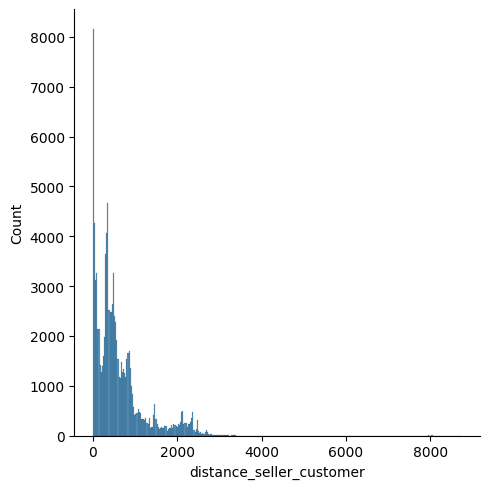

In [26]:
sns.displot(data = matching_geo, x ='distance_seller_customer')

👉 What is the median and the average seller-customer distance ?

In [27]:
matching_geo['distance_seller_customer'].describe()

count    98177.000000
mean       601.961534
std        596.877838
min          0.000000
25%        186.380313
50%        433.698770
75%        798.435455
max       8736.947618
Name: distance_seller_customer, dtype: float64

👀 Check your new dataframe and bring your code over to olist/order.py when it works. 

In [28]:
Order().get_distance_seller_customer()['distance_seller_customer']

0         301.005664
1         589.274140
2         312.495046
3         301.951753
4         646.221788
            ...     
98172    2755.314485
98173     354.848852
98174     338.827218
98175      72.870476
98176     133.230980
Name: distance_seller_customer, Length: 98177, dtype: float64

🧪  Test your code

In [29]:
from nbresult import ChallengeResult

result = ChallengeResult('distance',
    mean = Order().get_distance_seller_customer()['distance_seller_customer'].mean())
result.write()
print(result.check())


============================= test session starts ==============================
platform linux -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /home/saranjthilak92/.pyenv/versions/3.12.9/envs/lewagon/bin/python
cachedir: .pytest_cache
rootdir: /home/saranjthilak92/code/saranjthilak/04-Decision-Science/02-Statistical-Inference/data-orders
configfile: pytest.ini
plugins: typeguard-4.4.2, anyio-4.8.0
collecting ... collected 1 item

test_distance.py::TestDistance::test_distance PASSED                     [100%]

============================== 1 passed in 0.19s ===============================


💯 You can commit your code:

git add tests/distance.pickle

git commit -m 'Completed distance step'

git push origin master



Now also update `get_training_data` to merge the `get_distance_seller_customer` if `with_distance_seller_customer` is set to `True`.